## Use ridge regression to model polynomial 14th degree

Try ridge regression to see if regularization is helpful.

### Results:

At poly 14, adding L2 regularization doesn't add any significant increase in $R^2$.  The best Ridge alpha was 0.8 with $R^2$ of 0.5340, essentially the same as OLS.

It may be the case that if we increase to poly degree 15, we can do better.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [2]:
# Import sklearn stuff

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline,  make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
# read cleaned data
dfModelAll = pd.read_csv('../local/data/LBNL_openpv_tts_data/ModelAll.csv', index_col='row', dtype={'state':'category'})

In [5]:
dfModelAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364212 entries, 0 to 364211
Data columns (total 5 columns):
num_days         364212 non-null float64
size_kw          364212 non-null float64
state            364212 non-null category
cost_per_watt    364212 non-null float64
scaleSize        364212 non-null int64
dtypes: category(1), float64(3), int64(1)
memory usage: 14.2 MB


### Prep the dataset

### Important: since the data is sorted by time, it needs to be shuffed first or cross_val_score will pick bad sets.

In [6]:
dfMod = dfModelAll.sample(frac=1.0, random_state=21); dfMod.head()

,num_days,size_kw,state,cost_per_watt,scaleSize
row,,,,,
201275,6205.0,5.400,AZ,3.652963,2
298480,6692.0,8.990,CA,1.112347,3
237778,6478.0,9.810,CA,4.719164,3
237823,6479.0,7.848,CA,4.799949,3
78485,4540.0,7.524,AZ,5.927698,3


### do one-hot encoding of $state$

In [7]:
dfMod = pd.get_dummies(dfMod, drop_first=True)

In [8]:
dfMod.head()

,num_days,size_kw,cost_per_watt,scaleSize,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
row,,,,,,,,,,,,,,,,,,,,,,
201275,6205.0,5.400,3.652963,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
298480,6692.0,8.990,1.112347,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
237778,6478.0,9.810,4.719164,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
237823,6479.0,7.848,4.799949,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
78485,4540.0,7.524,5.927698,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Regress on time, size and state

In [9]:
theCols = dfMod.columns; theCols

Index(['num_days', 'size_kw', 'cost_per_watt', 'scaleSize', 'state_AZ',
       'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
       'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI'],
      dtype='object')

#### Prep for sklearn

In [10]:
#the whole dataset - prep data and target
X = dfMod[['num_days', 'size_kw', 'state_AZ',
              'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
              'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
              'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
y = dfMod[['cost_per_watt']]

### Bring in the right transformer

In [11]:
### make it an estimator and a transformer for general use
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

#### Helpful for column extractor

In [12]:
theStates = ['state_AZ', 'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
             'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OR', 
             'state_PA', 'state_TX', 'state_VT', 'state_WI']

#### Make a pipeline for Ridge

In [14]:
theRidgePipe = Pipeline([
    ('features', 
     FeatureUnion([('num_vars', 
                    Pipeline([('extract', ColumnExtractor(columns=['num_days', 'size_kw'])) ,
                              ('scale', StandardScaler()),
                              ('poly', PolynomialFeatures())
                              ])),
                   ('cat_vars',
                    ColumnExtractor(columns=theStates))
                  ]) # end of FeatureUnion
    ),
    ('Ridge', Ridge())
]) # end of Pipeline

### Ridge on polynomial transformation (excluding the one-hot encoded state from the expansion)

In [17]:
# check parameter names 
theRidgePipe.get_params().keys()

dict_keys(['memory', 'steps', 'features', 'Ridge', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__num_vars', 'features__cat_vars', 'features__num_vars__memory', 'features__num_vars__steps', 'features__num_vars__extract', 'features__num_vars__scale', 'features__num_vars__poly', 'features__num_vars__extract__columns', 'features__num_vars__scale__copy', 'features__num_vars__scale__with_mean', 'features__num_vars__scale__with_std', 'features__num_vars__poly__degree', 'features__num_vars__poly__include_bias', 'features__num_vars__poly__interaction_only', 'features__cat_vars__columns', 'Ridge__alpha', 'Ridge__copy_X', 'Ridge__fit_intercept', 'Ridge__max_iter', 'Ridge__normalize', 'Ridge__random_state', 'Ridge__solver', 'Ridge__tol'])

### Using poly 14 find best ridge alpha.

In [92]:
# capture RMSE and R2
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# use 100k data points for test
X = dfMod[['num_days', 'size_kw', 'state_AZ',
              'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD',
              'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
              'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']]
y = dfMod[['cost_per_watt']]

# Specify the hyperparameter space.
poly_space = np.array([14])
alpha_space = np.array([0.6, 0.8, 1.0, 1.2, 1.4])
# Create the hyperparameter grid
param_grid = {'features__num_vars__poly__degree': poly_space,
              'Ridge__alpha': alpha_space}            

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

# Create the GridSearchCV object: gm_cv
gs_cv = GridSearchCV(theRidgePipe, param_grid, cv=4, scoring=scoring, 
                     return_train_score=True, verbose=3, refit='Rsquared')

# Fit to the training set
model = gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = model.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] Ridge__alpha=0.6, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.685387615966425e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.6, features__num_vars__poly__degree=14, Rsquared=0.5352239524692688, RMSE=-1.4604077990246531, total=   4.2s
[CV] Ridge__alpha=0.6, features__num_vars__poly__degree=14 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s
C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5771913187456358e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.6, features__num_vars__poly__degree=14, Rsquared=0.5256206888723384, RMSE=-1.4836457557986749, total=   4.2s
[CV] Ridge__alpha=0.6, features__num_vars__poly__degree=14 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.8s remaining:    0.0s
C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.626107553122959e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.6, features__num_vars__poly__degree=14, Rsquared=0.5337262753968433, RMSE=-1.471264826054268, total=   4.6s
[CV] Ridge__alpha=0.6, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.723054595740081e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.6, features__num_vars__poly__degree=14, Rsquared=0.5310948174665933, RMSE=-1.47531872750902, total=   4.2s
[CV] Ridge__alpha=0.8, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.247183487955233e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.8, features__num_vars__poly__degree=14, Rsquared=0.5352215944988056, RMSE=-1.4604115035981837, total=   4.1s
[CV] Ridge__alpha=0.8, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.102921758327514e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.8, features__num_vars__poly__degree=14, Rsquared=0.5256174249946581, RMSE=-1.4836508597627653, total=   4.2s
[CV] Ridge__alpha=0.8, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.168143404163945e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.8, features__num_vars__poly__degree=14, Rsquared=0.5337386271399168, RMSE=-1.4712453387826103, total=   4.2s
[CV] Ridge__alpha=0.8, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.2974061276534407e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=0.8, features__num_vars__poly__degree=14, Rsquared=0.5310887524562191, RMSE=-1.4753282686644469, total=   4.3s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.8089793599440413e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=14, Rsquared=0.535218728991226, RMSE=-1.4604160055433397, total=   4.3s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6286521979093925e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=14, Rsquared=0.525616161063915, RMSE=-1.4836528362589345, total=   5.4s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7101792552049312e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=14, Rsquared=0.5337481232058312, RMSE=-1.4712303567203355, total=   4.2s
[CV] Ridge__alpha=1.0, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.871757659566801e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.0, features__num_vars__poly__degree=14, Rsquared=0.5310797349414604, RMSE=-1.4753424544304594, total=   4.2s
[CV] Ridge__alpha=1.2, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.3707752319328485e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.2, features__num_vars__poly__degree=14, Rsquared=0.535216582229221, RMSE=-1.4604193782717259, total=   4.2s
[CV] Ridge__alpha=1.2, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.1543826374912705e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.2, features__num_vars__poly__degree=14, Rsquared=0.5256119514639694, RMSE=-1.4836594190833592, total=   4.2s
[CV] Ridge__alpha=1.2, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.252215106245917e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.2, features__num_vars__poly__degree=14, Rsquared=0.5337571901512345, RMSE=-1.4712160515444892, total=   4.3s
[CV] Ridge__alpha=1.2, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.44610919148016e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.2, features__num_vars__poly__degree=14, Rsquared=0.5310746856246531, RMSE=-1.4753503976267266, total=   4.1s
[CV] Ridge__alpha=1.4, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.9325711039216576e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.4, features__num_vars__poly__degree=14, Rsquared=0.5352112086090597, RMSE=-1.4604278206085564, total=   4.3s
[CV] Ridge__alpha=1.4, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.680113077073149e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.4, features__num_vars__poly__degree=14, Rsquared=0.5256083154589555, RMSE=-1.4836651049166834, total=   4.6s
[CV] Ridge__alpha=1.4, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.794250957286904e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.4, features__num_vars__poly__degree=14, Rsquared=0.5337639398789833, RMSE=-1.4712054022180674, total=   5.4s
[CV] Ridge__alpha=1.4, features__num_vars__poly__degree=14 ...........


C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.020460723393521e-24 / 1.1102230246251565e-16
  RuntimeWarning)


[CV]  Ridge__alpha=1.4, features__num_vars__poly__degree=14, Rsquared=0.5310656241237253, RMSE=-1.4753646523747672, total=   6.0s


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.1min finished
C:\Users\saus\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6511941608115265e-24 / 1.1102230246251565e-16
  RuntimeWarning)


Best parameters: {'Ridge__alpha': 0.8, 'features__num_vars__poly__degree': 14}
test R squared: 0.5340077042277889


Best parameters: {'Ridge__alpha': 0.8, 'features__num_vars__poly__degree': 14}
test R squared: 0.5340077042277889


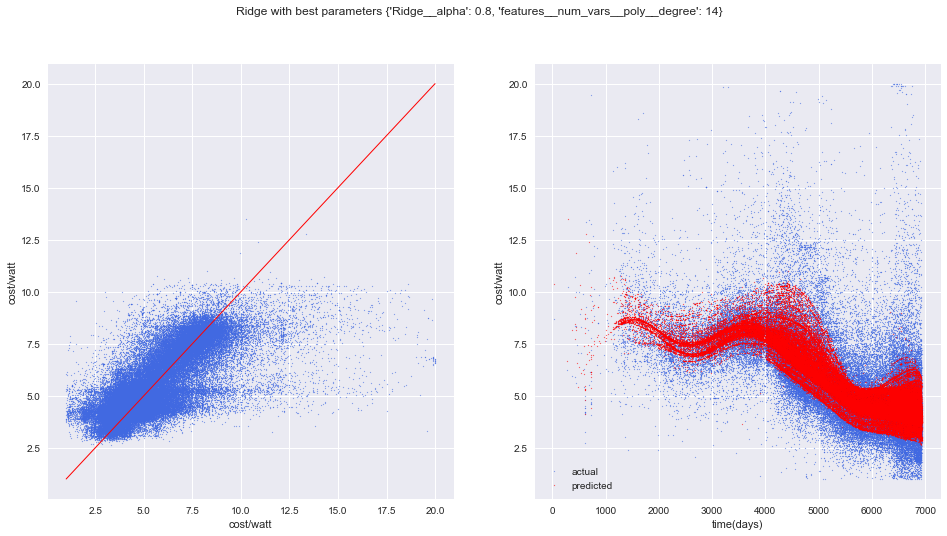

In [93]:
r2 = model.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sTitle = 'Ridge with best parameters {}'
fig.suptitle(sTitle.format(gs_cv.best_params_))

ax1.scatter(y_test, model.predict(X_test), marker='.', color='royalblue', s=4, alpha=0.5);
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red')
ax1.set_ylabel('cost/watt')
ax1.set_xlabel('cost/watt')

ax2.scatter(X_test.iloc[:, 0], y_test, marker='.', color='royalblue', s=4, alpha=0.5, label='actual')
ax2.scatter(X_test.iloc[:, 0], model.predict(X_test), marker='.', color='red', s=4, alpha=0.5, label='predicted')
ax2.set_ylabel('cost/watt')
ax2.set_xlabel('time(days)')
ax2.legend()
plt.show();

In [95]:
model.cv_results_

{'mean_fit_time': array([2.9579, 2.8152, 3.2118, 2.8722, 3.5614]),
 'mean_score_time': array([1.4469, 1.4935, 1.414 , 1.3867, 1.607 ]),
 'mean_test_RMSE': array([-1.4727, -1.4727, -1.4727, -1.4727, -1.4727]),
 'mean_test_Rsquared': array([0.5314, 0.5314, 0.5314, 0.5314, 0.5314]),
 'mean_train_RMSE': array([-1.4711, -1.4711, -1.4711, -1.4711, -1.4711]),
 'mean_train_Rsquared': array([0.5324, 0.5324, 0.5324, 0.5324, 0.5324]),
 'param_Ridge__alpha': masked_array(data=[0.6, 0.8, 1.0, 1.2, 1.4],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_features__num_vars__poly__degree': masked_array(data=[14, 14, 14, 14, 14],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'Ridge__alpha': 0.6, 'features__num_vars__poly__degree': 14},
  {'Ridge__alpha': 0.8, 'features__num_vars__poly__degree': 14},
  {'Ridge__alpha': 1.0, 'features__num_vars__poly__degree': 14},


In [87]:
def trainVsTestResults(results):
    ''' Plot test/train results for R^2 and RMSE'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sTitle = 'mean train/test RMSE and R^2 vs ridge alpha'
    fig.suptitle(sTitle)
          
    mean_train_RMSE = results['mean_train_RMSE']
    mean_test_RMSE = results['mean_test_RMSE']
    n = len(mean_train_RMSE)
        
    ax1.plot(results['param_Ridge__alpha'].data, np.abs(mean_train_RMSE), marker='d', alpha=1, color='green', label='train');
    ax1.plot(results['param_Ridge__alpha'].data, np.abs(mean_test_RMSE), marker='*', ms=10, alpha=0.5, color='red', label='test');
    ax1.set_ylabel('RMSE')
    ax1.set_xlabel('ridge alpha')
    ax1.set_title('mean train/test RMSE vs ridge alpha')
    ax1.legend()
    
    mean_train_R2 = results['mean_train_Rsquared']
    mean_test_R2 = results['mean_test_Rsquared']
    n = len(mean_train_R2)
    
    fig.suptitle(sTitle.format(gs_cv.best_params_['features__num_vars__poly__degree']))

    ax2.plot(results['param_Ridge__alpha'].data, np.abs(mean_train_R2), marker='d', alpha=1, color='green', label='train');
    ax2.plot(results['param_Ridge__alpha'].data, np.abs(mean_test_R2), marker='*', ms=10, alpha=0.5, color='red', label='test');
    ax2.set_ylabel('R^2')
    ax2.set_xlabel('ridge alpha')
    ax2.set_title('mean train/test R2 vs ridge alpha')
    ax2.legend()
          
    r2 = gs_cv.score(X_test, y_test)
    print("Best parameters: {}".format(gs_cv.best_params_))
    print("Best R squared: {}".format(r2))

Best parameters: {'Ridge__alpha': 0.8, 'features__num_vars__poly__degree': 14}
Best R squared: 0.5340077042277889


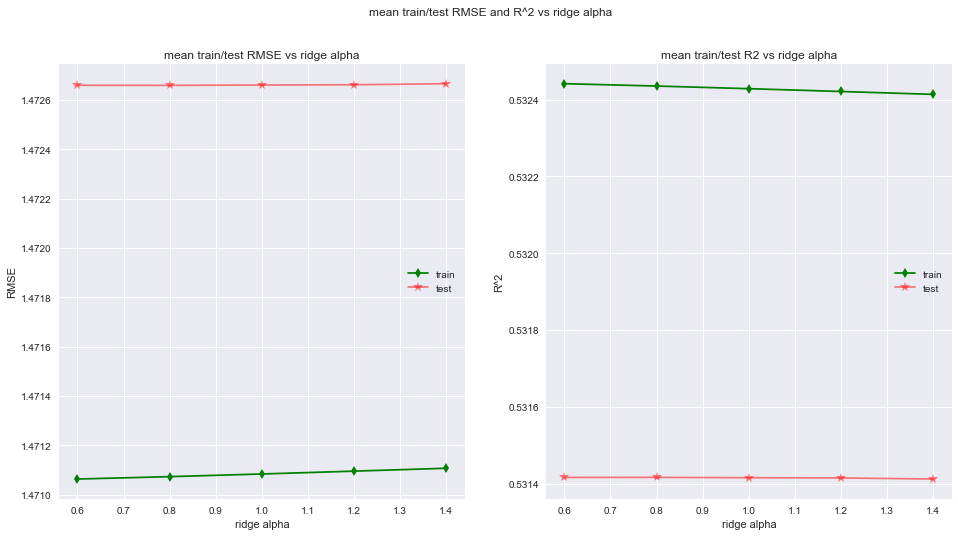

In [96]:
trainVsTestResults(model.cv_results_)